# Gas Flow Simulation

With `bluebonnet.flow`, you can solve pseudopressure over time and calculate how production declines and recovery factor increases. First, a few imports:

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bluebonnet.flow import (
    FlowProperties,
    IdealReservoir,
    SinglePhaseReservoir,
)
from bluebonnet.plotting import (
    plot_pseudopressure,
    plot_recovery_factor,
)

plt.style.use("ggplot")

## Ideal gas simulation

Ideal gas follows $pV=nRT$, with density varying linearly with pressure (at constant temperature). This is modeled with `IdealReservoir`. Viscosity is treated as a constant with this class.

In [2]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

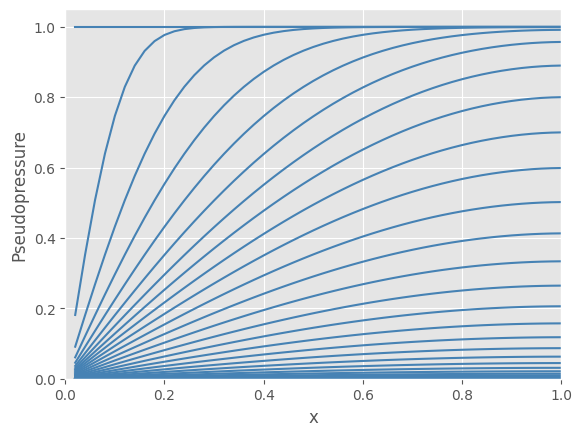

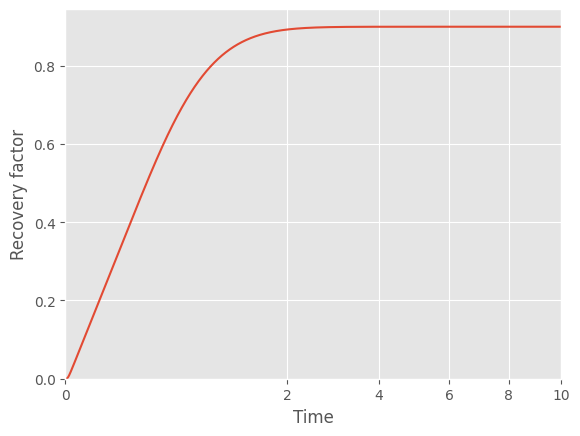

In [3]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor");

## Real gas simulation

For real gases, the z-factor and viscosity can vary with pressure. Thus, density is not linear with pressure. For an example, see the PVT table stored in the tests folder:

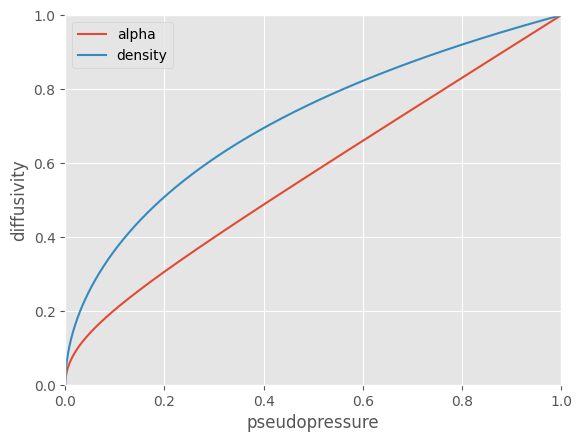

In [4]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
        "Density": "density",
    }
)


def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: x.alpha / max(x.alpha),
        density=lambda x: x.density / max(x.density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min())
        / (x["pseudopressure"].max() - x["pseudopressure"].min()),
    )[
        [
            "pressure",
            "pseudopressure",
            "alpha",
            "density",
            "z-factor",
            "compressibility",
            "viscosity",
        ]
    ]
    return out


flow_properties = FlowProperties(pvt_gas, p_i=12_000)

fluid_properties = scale_pressure_diffusivity(flow_properties.pvt_props)
ax = fluid_properties.plot(x="pseudopressure", y="alpha")
ax.set(ylim=(0, 1), xlim=(0, 1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax);

In a change from the ideal gas reservoir, we need to process the PVT table with `FlowProperties`, which becomes an argument passed to the `SinglePhaseReservoir` class. After that, simulating pseudopressure profiles and recovery factors are identical to the ideal reservoir case.

In [5]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

flow_properties = FlowProperties(pvt_gas, p_i=12_000)

res_realgas = SinglePhaseReservoir(50, 2000, 12000, flow_properties)

res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

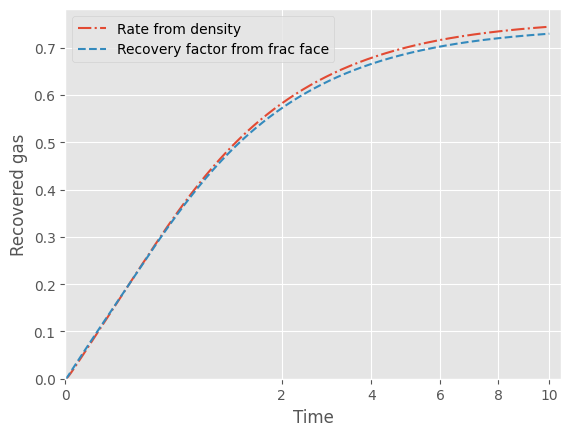

In [6]:
fig, ax = plt.subplots()
ax.plot(time, res_realgas.recovery_factor(density=True), "-.", label="Rate from density")
ax.plot(time, rf2, "--", label="Recovery factor from frac face")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovered gas",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
);

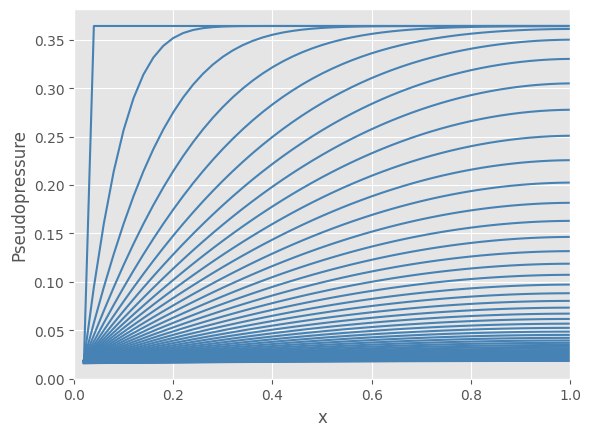

In [7]:
ax = plot_pseudopressure(res_realgas)

### Flow Curves

The recovery factor curves vary with fracture face pressure. Here, we run a series of simulations at different fracture face pressures and compare the resulting recovery factor.

In [8]:
p_i = 12000
rf = {}
for p_f in np.linspace(500, 2000, 3):
    print("Starting", p_f)

    flow_properties = FlowProperties(pvt_gas, p_i=p_i)
    res_realgas = SinglePhaseReservoir(50, p_f, p_i, flow_properties)

    res_realgas.simulate(time)
    rf[f"{p_f:.0f}"] = res_realgas.recovery_factor()

Starting 500.0
Starting 1250.0
Starting 2000.0


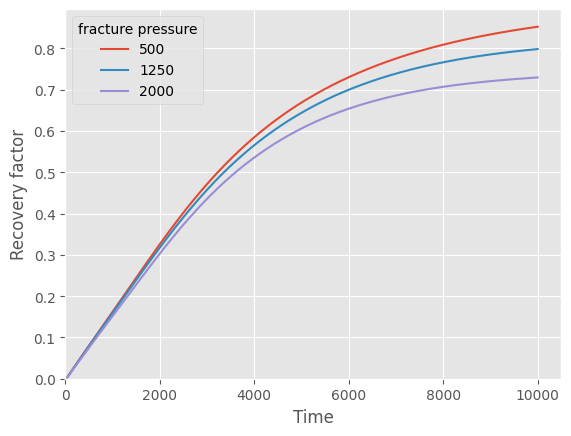

In [9]:
ax = pd.DataFrame(rf).plot()
ax.set(xlim=(0, None), ylim=(0, None), xlabel="Time", ylabel="Recovery factor")
ax.legend().set(title="fracture pressure");

Comparing the recovery factor for ideal versus real gases is enlightening. Because of the pressure variation of diffusivity, at real gas reservoirs asymptote more slowly than an ideal gas would.

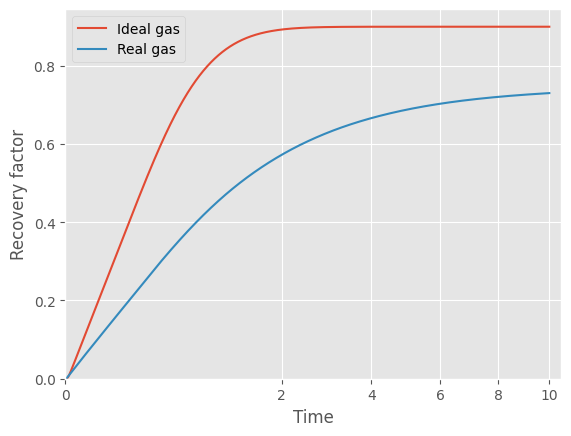

In [10]:
fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(
    xlabel="Time",
    ylabel="Recovery factor",
    ylim=(0, None),
    xscale="squareroot",
    xlim=(0, None),
);